In [1]:
# Import and preprocess data
import pandas as pd
from linearmodels import PooledOLS
import statsmodels.api as sm

In [10]:
evictions = pd.read_csv('evictions/cleaned_dallas_records.csv')
#dates = evictions.index.get_level_values('date').to_list()
# dataset[‘year’] = pd.Categorical(years)

In [129]:
demographics = pd.read_csv('demographics/dallas_acs_17_19.csv')
demographics = demographics.rename(columns={'Geo_FIPS':'tract_id'})
demographics.head()

,Unnamed: 0,tract_id,Geo_GEOID,Geo_NAME,Geo_QName,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_FILEID,Geo_LOGRECNO,...,SE_A10065_002,SE_A10066_001,SE_A10066_002,SE_A10066_003,SE_A10066_004,SE_A10066_005,SE_A10066_006,SE_A10066_007,SE_A10066_008,year
0,0,48113000100,14000US48113000100,"Census Tract 1, Dallas County, Texas","Census Tract 1, Dallas County, Texas",tx,140,0,ACSSF,5331,...,164,1876,696,537,341,226,65,11,0,2017
1,1,48113000201,14000US48113000201,"Census Tract 2.01, Dallas County, Texas","Census Tract 2.01, Dallas County, Texas",tx,140,0,ACSSF,5332,...,46,1437,614,440,162,151,28,26,16,2017
2,2,48113000202,14000US48113000202,"Census Tract 2.02, Dallas County, Texas","Census Tract 2.02, Dallas County, Texas",tx,140,0,ACSSF,5333,...,165,1875,676,796,210,130,52,0,11,2017
3,3,48113000300,14000US48113000300,"Census Tract 3, Dallas County, Texas","Census Tract 3, Dallas County, Texas",tx,140,0,ACSSF,5334,...,17,2026,727,756,354,118,24,26,21,2017
4,4,48113000401,14000US48113000401,"Census Tract 4.01, Dallas County, Texas","Census Tract 4.01, Dallas County, Texas",tx,140,0,ACSSF,5335,...,346,1778,666,445,180,294,108,32,53,2017


In [74]:
from pandas.tseries.offsets import Week

#df.Date.where(df.Date.dt.weekday == 0, df.Date - Week(weekday=0))
evictions['week_dt'] = pd.to_datetime(evictions['date']) - pd.to_timedelta(7, unit='d')
evictions['week_dt'] = evictions['week_dt'].where(evictions['week_dt'].dt.weekday == 0, evictions['week_dt'] - Week(weekday=0))
evictions_week_ts = evictions.groupby(['week_dt', 'tract_id']).size().sort_values(ascending=False).reset_index(name='count') 

In [75]:
evictions_week_ts = evictions_week_ts.sort_values("week_dt")
evictions_week_ts.week_dt.unique()

array(['2016-12-26T00:00:00.000000000', '2017-01-02T00:00:00.000000000',
       '2017-01-09T00:00:00.000000000', '2017-01-16T00:00:00.000000000',
       '2017-01-23T00:00:00.000000000', '2017-01-30T00:00:00.000000000',
       '2017-02-06T00:00:00.000000000', '2017-02-13T00:00:00.000000000',
       '2017-02-20T00:00:00.000000000', '2017-02-27T00:00:00.000000000',
       '2017-03-06T00:00:00.000000000', '2017-03-13T00:00:00.000000000',
       '2017-03-20T00:00:00.000000000', '2017-03-27T00:00:00.000000000',
       '2017-04-03T00:00:00.000000000', '2017-04-10T00:00:00.000000000',
       '2017-04-17T00:00:00.000000000', '2017-04-24T00:00:00.000000000',
       '2017-05-01T00:00:00.000000000', '2017-05-08T00:00:00.000000000',
       '2017-05-15T00:00:00.000000000', '2017-05-22T00:00:00.000000000',
       '2017-05-29T00:00:00.000000000', '2017-06-05T00:00:00.000000000',
       '2017-06-12T00:00:00.000000000', '2017-06-19T00:00:00.000000000',
       '2017-06-26T00:00:00.000000000', '2017-07-03

In [76]:
evictions_week_ts = evictions_week_ts.sort_values("week_dt")
evictions_week_ts.head()

,week_dt,tract_id,count
40528,2016-12-26,48113000201,1
10974,2016-12-26,48113011500,3
26839,2016-12-26,48113014603,1
26840,2016-12-26,48113015500,1
26841,2016-12-26,48113016100,1


In [77]:
all_weeks = evictions_week_ts.week_dt.unique()
all_tracts = []

In [78]:
for week in all_weeks:
    all_tracts.extend(evictions_week_ts.tract_id.unique())

all_tracts.sort()

In [79]:
all_weeks = []
for tract in evictions_week_ts.tract_id.unique():
    all_weeks.extend(evictions_week_ts.week_dt.unique())

#all_weeks.sort()

In [102]:
all_dallas = pd.DataFrame({'week_dt':all_weeks, 'tract_id': all_tracts})

In [103]:
all_dallas.head()

,week_dt,tract_id
0,2016-12-26,48085031317
1,2017-01-02,48085031317
2,2017-01-09,48085031317
3,2017-01-16,48085031317
4,2017-01-23,48085031317


In [104]:
all_dallas = all_dallas.merge(evictions_week_ts, how='left', on=['week_dt', 'tract_id'])

In [107]:
all_dallas['count'].isnull().sum()
#all_dallas.sort_values('count')

90691

In [108]:
len(all_dallas) - len(evictions_week_ts)

90691

In [114]:
all_dallas['year'] = all_dallas['week_dt'].dt.year
all_dallas['count'] = all_dallas['count'].fillna(0)

In [115]:
all_dallas.head()

,week_dt,tract_id,count,year
0,2016-12-26,48085031317,0.0,2016
1,2017-01-02,48085031317,1.0,2017
2,2017-01-09,48085031317,0.0,2017
3,2017-01-16,48085031317,0.0,2017
4,2017-01-23,48085031317,0.0,2017


In [131]:
#pd.merge_asof(all_dallas, evictions_week_ts, on=['year', 'tract_id'])
#pd.merge_asof(all_dallas, evictions_week_ts, left_index=True, right_on=['year', 'tract_id'])

all_dallas = all_dallas.merge(demographics, how = 'inner', on=['year', 'tract_id'])
all_dallas.drop(columns='Unnamed: 0')

,week_dt,tract_id,count,year,Geo_GEOID,Geo_NAME,Geo_QName,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,...,SE_A10065_001,SE_A10065_002,SE_A10066_001,SE_A10066_002,SE_A10066_003,SE_A10066_004,SE_A10066_005,SE_A10066_006,SE_A10066_007,SE_A10066_008
0,2017-01-02,48113000100,0.0,2017,14000US48113000100,"Census Tract 1, Dallas County, Texas","Census Tract 1, Dallas County, Texas",tx,140,0,...,925,164,1876,696,537,341,226,65,11,0
1,2017-01-09,48113000100,0.0,2017,14000US48113000100,"Census Tract 1, Dallas County, Texas","Census Tract 1, Dallas County, Texas",tx,140,0,...,925,164,1876,696,537,341,226,65,11,0
2,2017-01-16,48113000100,0.0,2017,14000US48113000100,"Census Tract 1, Dallas County, Texas","Census Tract 1, Dallas County, Texas",tx,140,0,...,925,164,1876,696,537,341,226,65,11,0
3,2017-01-23,48113000100,0.0,2017,14000US48113000100,"Census Tract 1, Dallas County, Texas","Census Tract 1, Dallas County, Texas",tx,140,0,...,925,164,1876,696,537,341,226,65,11,0
4,2017-01-30,48113000100,0.0,2017,14000US48113000100,"Census Tract 1, Dallas County, Texas","Census Tract 1, Dallas County, Texas",tx,140,0,...,925,164,1876,696,537,341,226,65,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81321,2019-12-02,48113020700,0.0,2019,14000US48113020700,Census Tract 207,"Census Tract 207, Dallas County, Texas",tx,140,0,...,454,136,2250,954,840,172,248,17,19,0
81322,2019-12-09,48113020700,0.0,2019,14000US48113020700,Census Tract 207,"Census Tract 207, Dallas County, Texas",tx,140,0,...,454,136,2250,954,840,172,248,17,19,0
81323,2019-12-16,48113020700,0.0,2019,14000US48113020700,Census Tract 207,"Census Tract 207, Dallas County, Texas",tx,140,0,...,454,136,2250,954,840,172,248,17,19,0
81324,2019-12-23,48113020700,0.0,2019,14000US48113020700,Census Tract 207,"Census Tract 207, Dallas County, Texas",tx,140,0,...,454,136,2250,954,840,172,248,17,19,0


In [133]:
all_dallas_multi = all_dallas.set_index(['week_dt', 'tract_id'])

In [147]:
# Perform PooledOLS
exog = sm.tools.tools.add_constant(all_dallas_multi['SE_A03001_003'])
endog = all_dallas_multi['count']
mod = PooledOLS(endog, exog)

pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)
# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/results.py:544: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  out_df: DataFrame = concat(out, 1)


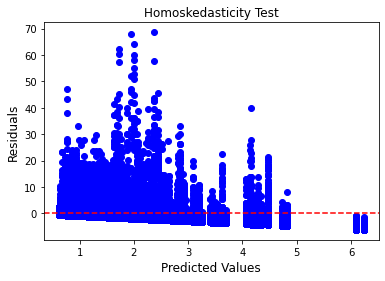

In [148]:
# 3A. Homoskedasticity
import matplotlib.pyplot as plt
 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 12)
ax.set_ylabel('Residuals', fontsize = 12)
ax.set_title('Homoskedasticity Test', fontsize = 12)
plt.show()

In [149]:
# 3A.2 White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
pooled_OLS_dataset = pd.concat([all_dallas_multi, residuals_pooled_OLS], axis=1)
pooled_OLS_dataset = pooled_OLS_dataset.drop(['year'], axis = 1).fillna(0)
exog = sm.tools.tools.add_constant(all_dallas_multi['SE_A03001_003']).fillna(0)
white_test_results = het_white(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test_results)))
# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results)))

{'LM-Stat': 866.2260200656593, 'LM p-val': 7.969107810376746e-189, 'F-Stat': 437.7597347425274, 'F p-val': 7.933588039393044e-190}
{'LM-Stat': 729.7052584141724, 'LM p-val': 1.0382205292984937e-160, 'F-Stat': 736.2937790818183, 'F p-val': 2.0186579714369127e-161}


/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [150]:
# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
print(durbin_watson_test_results)

1.697460814474603


In [151]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects
exog = sm.tools.tools.add_constant(all_dallas_multi['SE_A03001_003'])
endog = all_dallas_multi['count']
# random effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 
# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects = True) 
fe_res = model_fe.fit() 
#print results
print(re_res)
print(fe_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  count   R-squared:                        0.0623
Estimator:              RandomEffects   R-squared (Between):              0.0006
No. Observations:               81326   R-squared (Within):               0.0624
Date:                Tue, Oct 05 2021   R-squared (Overall):              0.0586
Time:                        10:15:24   Log-likelihood                -1.977e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      5406.1
Entities:                         157   P-value                           0.0000
Avg Obs:                       518.00   Distribution:                 F(1,81324)
Min Obs:                       518.00                                           
Max Obs:                       518.00   F-statistic (robust):             5406.1
                            

In [164]:

# make our formula:

formula = 'count ~ SE_A03001_003 + SE_A06001_005 + SE_A08002B_003 + SE_A10039B_009 + SE_B18002_003 + SE_B18002_002 + SE_A10011_003'


# Perform PooledOLS
mod2 = PooledOLS.from_formula(formula, all_dallas_multi)

pooledOLS_res2 = mod2.fit(cov_type='clustered', cluster_entity=True)
# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS2 = pooledOLS_res2.predict().fitted_values
residuals_pooled_OLS2 = pooledOLS_res2.resids

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/results.py:544: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  out_df: DataFrame = concat(out, 1)


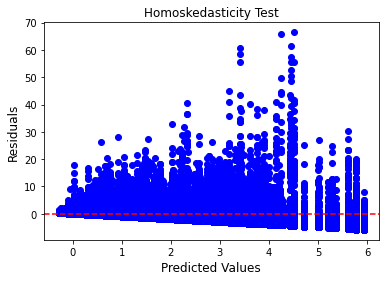

In [165]:
# 3A. Homoskedasticity
import matplotlib.pyplot as plt
 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS2, residuals_pooled_OLS2, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 12)
ax.set_ylabel('Residuals', fontsize = 12)
ax.set_title('Homoskedasticity Test', fontsize = 12)
plt.show()

In [178]:
# 3A.2 White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
pooled_OLS_dataset2 = pd.concat([all_dallas_multi, residuals_pooled_OLS2], axis=1)
pooled_OLS_dataset2 = pooled_OLS_dataset2.drop(['year'], axis = 1).fillna(0)

white_test_results = het_white(pooledOLS_res2.resids, pooledOLS_res2.model.exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test_results)))
# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results)))

TypeError: float() argument must be a string or a number, not 'PanelData'

In [166]:
# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(fittedvals_pooled_OLS2['residual']) 
print(durbin_watson_test_results)

KeyError: 'residual'

In [163]:
# fixed effects model
model2_fe = PanelOLS.from_formula(, data=all_dallas_multi) 
fe_res = model2_fe.fit() 
#print results
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  count   R-squared:                        0.2812
Estimator:                   PanelOLS   R-squared (Between):              0.7405
No. Observations:               81326   R-squared (Within):               0.1651
Date:                Tue, Oct 05 2021   R-squared (Overall):              0.2812
Time:                        10:48:09   Log-likelihood                 -1.96e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      4544.3
Entities:                         157   P-value                           0.0000
Avg Obs:                       518.00   Distribution:                 F(7,81319)
Min Obs:                       518.00                                           
Max Obs:                       518.00   F-statistic (robust):             4544.3
                            